In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
from collections import OrderedDict
import os
import neptune
from neptune.utils import stringify_unsupported

plt.style.use('ggplot')

# PARAMETERS - GENERAL

In [19]:
stftSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/freqRTheta.npz'
timeDomainSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeDomain.npz'
timeFreqSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeFreqRTheta.npz'

modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/model.pth'

neptuneProject = 'jettinger35/predictScalp'
api_token = os.environ.get('NEPTUNE_API_TOKEN')

subsampleFreq = 128   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# PARAMETERS - TRAINING

In [3]:
epochs = 5000
batch_size = 1024
learningRate = 1e-3
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optChoice = 'adam'

patience = 5000

# UTILITY FUNCTIONS

In [4]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

class NeuralNetwork(nn.Module):
    
    def __init__(self, layerOrderedDict):
        super().__init__()
        self.model = nn.Sequential(layerOrderedDict)
        
    def forward(self, x):
        return self.model(x)
    
    
# GIVEN A LIST OF LAYER SIZES MAKE AN ORDERED DICTIONARY FOR INITIALIZING A PYTORCH NET

def listToOrderedDict(sizeList):
    n = len(sizeList)
    tupleList = []
    for i in range(n - 1):
        tupleList.append(('bn%s' % str(i), nn.BatchNorm1d(sizeList[i])))
        tupleList.append(('l%s' % str(i), nn.Linear(sizeList[i], sizeList[i+1])))
        tupleList.append(('r%s' % str(i), nn.ReLU()))
    return OrderedDict(tupleList[:-1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# LOAD NUMPY DATA ARRAYS

In [5]:
dataSwitch = 'time'

if dataSwitch == 'freq':
    # STFT DATA

    npzfile = np.load(stftSavePath)
    x_trainRTheta = npzfile['x_trainRTheta']
    x_validRTheta = npzfile['x_validRTheta'] 
    y_trainRTheta = npzfile['y_trainRTheta'] 
    y_validRTheta = npzfile['y_validRTheta']

    trainXTensor = torch.Tensor(x_trainRTheta)
    trainYTensor = torch.Tensor(y_trainRTheta)
    validXTensor = torch.Tensor(x_validRTheta)
    validYTensor = torch.Tensor(y_validRTheta)

elif dataSwitch == 'time':
    # TIME DOMAIN DATA

    npzfile = np.load(timeDomainSavePath)
    xTrainTimeDomain = npzfile['xTrainTimeDomain']
    xValidTimeDomain = npzfile['xValidTimeDomain'] 
    yTrainTimeDomain = npzfile['yTrainTimeDomain'] 
    yValidTimeDomain = npzfile['yValidTimeDomain']

    trainXTensor = torch.Tensor(xTrainTimeDomain)
    trainYTensor = torch.Tensor(yTrainTimeDomain)
    validXTensor = torch.Tensor(xValidTimeDomain)
    validYTensor = torch.Tensor(yValidTimeDomain)
    
elif dataSwitch == 'timeFreq':
    
    npzfile = np.load(timeFreqSavePath)
    xTrain = npzfile['x_trainTimeFreq']
    xValid = npzfile['x_validTimeFreq'] 
    yTrain = npzfile['y_trainTimeFreq'] 
    yValid = npzfile['y_validTimeFreq']

    trainXTensor = torch.Tensor(xTrain)
    trainYTensor = torch.Tensor(yTrain)
    validXTensor = torch.Tensor(xValid)
    validYTensor = torch.Tensor(yValid)

In [6]:
# CREATE PYTORCH DATALOADERS

trainDataset = TensorDataset(trainXTensor,trainYTensor)
trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

validDataset = TensorDataset(validXTensor,validYTensor)
validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)


print("train: ")
for X, y in trainDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
print("\ntest: ")
for X, y in validDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train: 
Shape of X [N, C, H, W]: torch.Size([1024, 5655])
Shape of y: torch.Size([1024, 1]) torch.float32

test: 
Shape of X [N, C, H, W]: torch.Size([1024, 5655])
Shape of y: torch.Size([1024, 1]) torch.float32


# DEFINE OR LOAD THE MODEL

In [7]:
# DEFINE MODEL

modelLoadFlag = False

if modelLoadFlag == True:
    model = torch.load(modelPath)
    bestTestLoss = test(validDataLoader, model, loss_fn)
else:
    # DEFINE ARCHITECTURE HERE
    hiddenLayerSizes = [512,512,512,512,512]
    
    layerSizeList = [trainXTensor.shape[1]] + hiddenLayerSizes + [trainYTensor.shape[1]]
    layerOrderedDict = listToOrderedDict(layerSizeList)
    
    model = NeuralNetwork(layerOrderedDict)
    bestTestLoss = float('inf')
    
print("Number of parameters: ", count_parameters(model))
model = model.to(device)
print(model)

Number of parameters:  3963439
NeuralNetwork(
  (model): Sequential(
    (bn0): BatchNorm1d(5655, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l0): Linear(in_features=5655, out_features=512, bias=True)
    (r0): ReLU()
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l1): Linear(in_features=512, out_features=512, bias=True)
    (r1): ReLU()
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l2): Linear(in_features=512, out_features=512, bias=True)
    (r2): ReLU()
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l3): Linear(in_features=512, out_features=512, bias=True)
    (r3): ReLU()
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l4): Linear(in_features=512, out_features=512, bias=True)
    (r4): ReLU()
    (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, tra

# TRAIN (LOG DATA TO NEPTUNE)

In [8]:
if optChoice == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
elif optChoice == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
else:
    optimizer = None
    print('no optimizer chosen...')

run = neptune.init_run(
    project=neptuneProject,
    api_token=api_token,  
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

PARAMS = {
    "batch_size": batch_size,
    "learning_rate": learningRate,
    "optimizer": optChoice,
    "patience": patience,
    "subsampleFreq": subsampleFreq,
    "secondsInWindow": secondsInWindow,
    "nperseg": nperseg,
    "noverlap": noverlap,
    "window": stringify_unsupported(window),
    "loss_fn": stringify_unsupported(loss_fn),
    "architectureString": str(model),
    "numParameters": count_parameters(model)
}
run["parameters"] = PARAMS

noImprovementCount = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainDataLoader, model, loss_fn, optimizer)
    test_loss = test(validDataLoader, model, loss_fn)
    
    if test_loss < bestTestLoss:
        noImprovementCount = 0
        bestTestLoss = test_loss
        torch.save(model, modelPath)
        run["model_best"].upload(modelPath)
        run["best_test_loss"] =  bestTestLoss
        run["best_test_epoch"] = t
        print("\nSaved a new best model!\n")
    else:
        noImprovementCount = noImprovementCount + 1
        
    run["train/loss"].append(train_loss)
    run["test/loss"].append(test_loss)
    
    if noImprovementCount >= patience:   
        print("Early stopping invoked....")
        break
        
run.stop()
print("Done!")

https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-38
Epoch 1
-------------------------------
loss: 0.785791  [ 1024/176128]
Test Error: 
 Avg loss: 0.671459 


Saved a new best model!

Epoch 2
-------------------------------
loss: 0.798394  [ 1024/176128]
Test Error: 
 Avg loss: 0.703098 

Epoch 3
-------------------------------
loss: 1.949186  [ 1024/176128]
Test Error: 
 Avg loss: 0.694761 

Epoch 4
-------------------------------
loss: 0.776859  [ 1024/176128]
Test Error: 
 Avg loss: 0.659208 


Saved a new best model!

Epoch 5
-------------------------------
loss: 0.810638  [ 1024/176128]
Test Error: 
 Avg loss: 0.654525 


Saved a new best model!

Epoch 6
-------------------------------
loss: 0.708198  [ 1024/176128]
Test Error: 
 Avg loss: 0.643646 


Saved a new best model!

Epoch 7
-------------------------------
loss: 0.630915  [ 1024/176128]
Test Error: 
 Avg loss: 0.632530 


Saved a new best model!

Epoch 8
-------------------------------
loss: 0.605462  [ 1024/1761

Test Error: 
 Avg loss: 0.449590 

Epoch 67
-------------------------------
loss: 0.389150  [ 1024/176128]
Test Error: 
 Avg loss: 0.450930 

Epoch 68
-------------------------------
loss: 0.375273  [ 1024/176128]
Test Error: 
 Avg loss: 0.445318 

Epoch 69
-------------------------------
loss: 0.381710  [ 1024/176128]
Test Error: 
 Avg loss: 0.446418 

Epoch 70
-------------------------------
loss: 0.397980  [ 1024/176128]
Test Error: 
 Avg loss: 0.448903 

Epoch 71
-------------------------------
loss: 0.355734  [ 1024/176128]
Test Error: 
 Avg loss: 0.446134 

Epoch 72
-------------------------------
loss: 0.368665  [ 1024/176128]
Test Error: 
 Avg loss: 0.457553 

Epoch 73
-------------------------------
loss: 0.384515  [ 1024/176128]
Test Error: 
 Avg loss: 0.457716 

Epoch 74
-------------------------------
loss: 0.390388  [ 1024/176128]
Test Error: 
 Avg loss: 0.446457 

Epoch 75
-------------------------------
loss: 0.365209  [ 1024/176128]
Test Error: 
 Avg loss: 0.447293 

Ep

Test Error: 
 Avg loss: 0.444657 

Epoch 140
-------------------------------
loss: 0.320114  [ 1024/176128]
Test Error: 
 Avg loss: 0.443278 

Epoch 141
-------------------------------
loss: 0.324964  [ 1024/176128]
Test Error: 
 Avg loss: 0.431989 

Epoch 142
-------------------------------
loss: 0.295382  [ 1024/176128]
Test Error: 
 Avg loss: 0.442085 

Epoch 143
-------------------------------
loss: 0.317445  [ 1024/176128]
Test Error: 
 Avg loss: 0.442030 

Epoch 144
-------------------------------
loss: 0.309708  [ 1024/176128]
Test Error: 
 Avg loss: 0.440049 

Epoch 145
-------------------------------
loss: 0.319654  [ 1024/176128]
Test Error: 
 Avg loss: 0.451621 

Epoch 146
-------------------------------
loss: 0.335003  [ 1024/176128]
Test Error: 
 Avg loss: 0.440925 

Epoch 147
-------------------------------
loss: 0.302831  [ 1024/176128]
Test Error: 
 Avg loss: 0.456185 

Epoch 148
-------------------------------
loss: 0.319612  [ 1024/176128]
Test Error: 
 Avg loss: 0.47

Test Error: 
 Avg loss: 0.427216 

Epoch 214
-------------------------------
loss: 0.284873  [ 1024/176128]
Test Error: 
 Avg loss: 0.424280 

Epoch 215
-------------------------------
loss: 0.284874  [ 1024/176128]
Test Error: 
 Avg loss: 0.428494 

Epoch 216
-------------------------------
loss: 0.294687  [ 1024/176128]
Test Error: 
 Avg loss: 0.430328 

Epoch 217
-------------------------------
loss: 0.259541  [ 1024/176128]
Test Error: 
 Avg loss: 0.431326 

Epoch 218
-------------------------------
loss: 0.274872  [ 1024/176128]
Test Error: 
 Avg loss: 0.441163 

Epoch 219
-------------------------------
loss: 0.300072  [ 1024/176128]
Test Error: 
 Avg loss: 0.442284 

Epoch 220
-------------------------------
loss: 0.290209  [ 1024/176128]
Test Error: 
 Avg loss: 0.442110 

Epoch 221
-------------------------------
loss: 0.277450  [ 1024/176128]
Test Error: 
 Avg loss: 0.447465 

Epoch 222
-------------------------------
loss: 0.296263  [ 1024/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.435879 

Epoch 290
-------------------------------
loss: 0.253830  [ 1024/176128]
Test Error: 
 Avg loss: 0.445693 

Epoch 291
-------------------------------
loss: 0.268470  [ 1024/176128]
Test Error: 
 Avg loss: 0.450919 

Epoch 292
-------------------------------
loss: 0.268768  [ 1024/176128]
Test Error: 
 Avg loss: 0.449884 

Epoch 293
-------------------------------
loss: 0.253484  [ 1024/176128]
Test Error: 
 Avg loss: 0.451789 

Epoch 294
-------------------------------
loss: 0.262866  [ 1024/176128]
Test Error: 
 Avg loss: 0.454556 

Epoch 295
-------------------------------
loss: 0.269376  [ 1024/176128]
Test Error: 
 Avg loss: 0.456553 

Epoch 296
-------------------------------
loss: 0.262425  [ 1024/176128]
Test Error: 
 Avg loss: 0.455581 

Epoch 297
-------------------------------
loss: 0.296194  [ 1024/176128]
Test Error: 
 Avg loss: 0.432332 

Epoch 298
-------------------------------
loss: 0.258738  [ 1024/176128]
Test Error: 
 Avg loss: 0.41

Test Error: 
 Avg loss: 0.431998 

Epoch 366
-------------------------------
loss: 0.239950  [ 1024/176128]
Test Error: 
 Avg loss: 0.434813 

Epoch 367
-------------------------------
loss: 0.248537  [ 1024/176128]
Test Error: 
 Avg loss: 0.435667 

Epoch 368
-------------------------------
loss: 0.242548  [ 1024/176128]
Test Error: 
 Avg loss: 0.438722 

Epoch 369
-------------------------------
loss: 0.242686  [ 1024/176128]
Test Error: 
 Avg loss: 0.440368 

Epoch 370
-------------------------------
loss: 0.245840  [ 1024/176128]
Test Error: 
 Avg loss: 0.447765 

Epoch 371
-------------------------------
loss: 0.254146  [ 1024/176128]
Test Error: 
 Avg loss: 0.440764 

Epoch 372
-------------------------------
loss: 0.251678  [ 1024/176128]
Test Error: 
 Avg loss: 0.438535 

Epoch 373
-------------------------------
loss: 0.245620  [ 1024/176128]
Test Error: 
 Avg loss: 0.452647 

Epoch 374
-------------------------------
loss: 0.258068  [ 1024/176128]
Test Error: 
 Avg loss: 0.45

Test Error: 
 Avg loss: 0.431669 

Epoch 442
-------------------------------
loss: 0.216975  [ 1024/176128]
Test Error: 
 Avg loss: 0.428032 

Epoch 443
-------------------------------
loss: 0.226260  [ 1024/176128]
Test Error: 
 Avg loss: 0.426094 

Epoch 444
-------------------------------
loss: 0.225602  [ 1024/176128]
Test Error: 
 Avg loss: 0.428637 

Epoch 445
-------------------------------
loss: 0.212749  [ 1024/176128]
Test Error: 
 Avg loss: 0.432346 

Epoch 446
-------------------------------
loss: 0.211170  [ 1024/176128]
Test Error: 
 Avg loss: 0.427683 

Epoch 447
-------------------------------
loss: 0.221471  [ 1024/176128]
Test Error: 
 Avg loss: 0.430941 

Epoch 448
-------------------------------
loss: 0.209838  [ 1024/176128]
Test Error: 
 Avg loss: 0.438244 

Epoch 449
-------------------------------
loss: 0.220357  [ 1024/176128]
Test Error: 
 Avg loss: 0.434989 

Epoch 450
-------------------------------
loss: 0.230520  [ 1024/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.436579 

Epoch 518
-------------------------------
loss: 0.218296  [ 1024/176128]
Test Error: 
 Avg loss: 0.432867 

Epoch 519
-------------------------------
loss: 0.200213  [ 1024/176128]
Test Error: 
 Avg loss: 0.438601 

Epoch 520
-------------------------------
loss: 0.210870  [ 1024/176128]
Test Error: 
 Avg loss: 0.440955 

Epoch 521
-------------------------------
loss: 0.239245  [ 1024/176128]
Test Error: 
 Avg loss: 0.429293 

Epoch 522
-------------------------------
loss: 0.207692  [ 1024/176128]
Test Error: 
 Avg loss: 0.421125 

Epoch 523
-------------------------------
loss: 0.221346  [ 1024/176128]
Test Error: 
 Avg loss: 0.421364 

Epoch 524
-------------------------------
loss: 0.207417  [ 1024/176128]
Test Error: 
 Avg loss: 0.427429 

Epoch 525
-------------------------------
loss: 0.214976  [ 1024/176128]
Test Error: 
 Avg loss: 0.427898 

Epoch 526
-------------------------------
loss: 0.203220  [ 1024/176128]
Test Error: 
 Avg loss: 0.43

Test Error: 
 Avg loss: 0.422674 

Epoch 594
-------------------------------
loss: 0.183154  [ 1024/176128]
Test Error: 
 Avg loss: 0.418199 

Epoch 595
-------------------------------
loss: 0.191963  [ 1024/176128]
Test Error: 
 Avg loss: 0.427070 

Epoch 596
-------------------------------
loss: 0.184497  [ 1024/176128]
Test Error: 
 Avg loss: 0.428829 

Epoch 597
-------------------------------
loss: 0.192561  [ 1024/176128]
Test Error: 
 Avg loss: 0.425303 

Epoch 598
-------------------------------
loss: 0.194530  [ 1024/176128]
Test Error: 
 Avg loss: 0.427660 

Epoch 599
-------------------------------
loss: 0.206102  [ 1024/176128]
Test Error: 
 Avg loss: 0.428492 

Epoch 600
-------------------------------
loss: 0.205702  [ 1024/176128]
Test Error: 
 Avg loss: 0.421696 

Epoch 601
-------------------------------
loss: 0.202257  [ 1024/176128]
Test Error: 
 Avg loss: 0.414489 


Saved a new best model!

Epoch 602
-------------------------------
loss: 0.208108  [ 1024/176128]
Te

Test Error: 
 Avg loss: 0.424096 

Epoch 670
-------------------------------
loss: 0.188484  [ 1024/176128]
Test Error: 
 Avg loss: 0.424863 

Epoch 671
-------------------------------
loss: 0.182601  [ 1024/176128]
Test Error: 
 Avg loss: 0.430158 

Epoch 672
-------------------------------
loss: 0.172430  [ 1024/176128]
Test Error: 
 Avg loss: 0.434591 

Epoch 673
-------------------------------
loss: 0.186775  [ 1024/176128]
Test Error: 
 Avg loss: 0.439654 

Epoch 674
-------------------------------
loss: 0.188390  [ 1024/176128]
Test Error: 
 Avg loss: 0.442608 

Epoch 675
-------------------------------
loss: 0.193349  [ 1024/176128]
Test Error: 
 Avg loss: 0.432895 

Epoch 676
-------------------------------
loss: 0.202286  [ 1024/176128]
Test Error: 
 Avg loss: 0.427469 

Epoch 677
-------------------------------
loss: 0.190328  [ 1024/176128]
Test Error: 
 Avg loss: 0.429188 

Epoch 678
-------------------------------
loss: 0.200970  [ 1024/176128]
Test Error: 
 Avg loss: 0.43

Test Error: 
 Avg loss: 0.427440 

Epoch 746
-------------------------------
loss: 0.197350  [ 1024/176128]
Test Error: 
 Avg loss: 0.423839 

Epoch 747
-------------------------------
loss: 0.184767  [ 1024/176128]
Test Error: 
 Avg loss: 0.424756 

Epoch 748
-------------------------------
loss: 0.182609  [ 1024/176128]
Test Error: 
 Avg loss: 0.434243 

Epoch 749
-------------------------------
loss: 0.185167  [ 1024/176128]
Test Error: 
 Avg loss: 0.436005 

Epoch 750
-------------------------------
loss: 0.179861  [ 1024/176128]
Test Error: 
 Avg loss: 0.428940 

Epoch 751
-------------------------------
loss: 0.178168  [ 1024/176128]
Test Error: 
 Avg loss: 0.421936 

Epoch 752
-------------------------------
loss: 0.187545  [ 1024/176128]
Test Error: 
 Avg loss: 0.417902 

Epoch 753
-------------------------------
loss: 0.178779  [ 1024/176128]
Test Error: 
 Avg loss: 0.417815 

Epoch 754
-------------------------------
loss: 0.175325  [ 1024/176128]
Test Error: 
 Avg loss: 0.41

Test Error: 
 Avg loss: 0.430616 

Epoch 822
-------------------------------
loss: 0.171545  [ 1024/176128]
Test Error: 
 Avg loss: 0.439273 

Epoch 823
-------------------------------
loss: 0.180478  [ 1024/176128]
Test Error: 
 Avg loss: 0.443657 

Epoch 824
-------------------------------
loss: 0.173128  [ 1024/176128]
Test Error: 
 Avg loss: 0.437322 

Epoch 825
-------------------------------
loss: 0.185712  [ 1024/176128]
Test Error: 
 Avg loss: 0.432462 

Epoch 826
-------------------------------
loss: 0.162115  [ 1024/176128]
Test Error: 
 Avg loss: 0.431447 

Epoch 827
-------------------------------
loss: 0.182252  [ 1024/176128]
Test Error: 
 Avg loss: 0.427272 

Epoch 828
-------------------------------
loss: 0.179003  [ 1024/176128]
Test Error: 
 Avg loss: 0.423864 

Epoch 829
-------------------------------
loss: 0.177867  [ 1024/176128]
Test Error: 
 Avg loss: 0.422300 

Epoch 830
-------------------------------
loss: 0.163318  [ 1024/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.432592 

Epoch 898
-------------------------------
loss: 0.176533  [ 1024/176128]
Test Error: 
 Avg loss: 0.429280 

Epoch 899
-------------------------------
loss: 0.166706  [ 1024/176128]
Test Error: 
 Avg loss: 0.421145 

Epoch 900
-------------------------------
loss: 0.171213  [ 1024/176128]
Test Error: 
 Avg loss: 0.418850 

Epoch 901
-------------------------------
loss: 0.181665  [ 1024/176128]
Test Error: 
 Avg loss: 0.425380 

Epoch 902
-------------------------------
loss: 0.187751  [ 1024/176128]
Test Error: 
 Avg loss: 0.431377 

Epoch 903
-------------------------------
loss: 0.174396  [ 1024/176128]
Test Error: 
 Avg loss: 0.432648 

Epoch 904
-------------------------------
loss: 0.168103  [ 1024/176128]
Test Error: 
 Avg loss: 0.433304 

Epoch 905
-------------------------------
loss: 0.182755  [ 1024/176128]
Test Error: 
 Avg loss: 0.432330 

Epoch 906
-------------------------------
loss: 0.174494  [ 1024/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.421442 

Epoch 974
-------------------------------
loss: 0.175090  [ 1024/176128]
Test Error: 
 Avg loss: 0.422983 

Epoch 975
-------------------------------
loss: 0.175769  [ 1024/176128]
Test Error: 
 Avg loss: 0.422013 

Epoch 976
-------------------------------
loss: 0.171246  [ 1024/176128]
Test Error: 
 Avg loss: 0.426556 

Epoch 977
-------------------------------
loss: 0.160220  [ 1024/176128]
Test Error: 
 Avg loss: 0.434510 

Epoch 978
-------------------------------
loss: 0.157798  [ 1024/176128]
Test Error: 
 Avg loss: 0.438334 

Epoch 979
-------------------------------
loss: 0.172008  [ 1024/176128]
Test Error: 
 Avg loss: 0.435303 

Epoch 980
-------------------------------
loss: 0.164086  [ 1024/176128]
Test Error: 
 Avg loss: 0.426654 

Epoch 981
-------------------------------
loss: 0.149910  [ 1024/176128]
Test Error: 
 Avg loss: 0.421051 

Epoch 982
-------------------------------
loss: 0.168482  [ 1024/176128]
Test Error: 
 Avg loss: 0.41

Test Error: 
 Avg loss: 0.420810 

Epoch 1050
-------------------------------
loss: 0.168744  [ 1024/176128]
Test Error: 
 Avg loss: 0.419323 

Epoch 1051
-------------------------------
loss: 0.175445  [ 1024/176128]
Test Error: 
 Avg loss: 0.419946 

Epoch 1052
-------------------------------
loss: 0.167165  [ 1024/176128]
Test Error: 
 Avg loss: 0.421642 

Epoch 1053
-------------------------------
loss: 0.162105  [ 1024/176128]
Test Error: 
 Avg loss: 0.419766 

Epoch 1054
-------------------------------
loss: 0.162652  [ 1024/176128]
Test Error: 
 Avg loss: 0.421751 

Epoch 1055
-------------------------------
loss: 0.172453  [ 1024/176128]
Test Error: 
 Avg loss: 0.428838 

Epoch 1056
-------------------------------
loss: 0.165781  [ 1024/176128]
Test Error: 
 Avg loss: 0.429174 

Epoch 1057
-------------------------------
loss: 0.159444  [ 1024/176128]
Test Error: 
 Avg loss: 0.419349 

Epoch 1058
-------------------------------
loss: 0.177274  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.422242 

Epoch 1125
-------------------------------
loss: 0.157197  [ 1024/176128]
Test Error: 
 Avg loss: 0.418191 

Epoch 1126
-------------------------------
loss: 0.150813  [ 1024/176128]
Test Error: 
 Avg loss: 0.417847 

Epoch 1127
-------------------------------
loss: 0.154003  [ 1024/176128]
Test Error: 
 Avg loss: 0.415103 

Epoch 1128
-------------------------------
loss: 0.167062  [ 1024/176128]
Test Error: 
 Avg loss: 0.414540 

Epoch 1129
-------------------------------
loss: 0.159669  [ 1024/176128]
Test Error: 
 Avg loss: 0.420969 

Epoch 1130
-------------------------------
loss: 0.177370  [ 1024/176128]
Test Error: 
 Avg loss: 0.422230 

Epoch 1131
-------------------------------
loss: 0.177372  [ 1024/176128]
Test Error: 
 Avg loss: 0.424874 

Epoch 1132
-------------------------------
loss: 0.178258  [ 1024/176128]
Test Error: 
 Avg loss: 0.427206 

Epoch 1133
-------------------------------
loss: 0.158526  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.420393 

Epoch 1201
-------------------------------
loss: 0.153771  [ 1024/176128]
Test Error: 
 Avg loss: 0.423028 

Epoch 1202
-------------------------------
loss: 0.148642  [ 1024/176128]
Test Error: 
 Avg loss: 0.430280 

Epoch 1203
-------------------------------
loss: 0.164922  [ 1024/176128]
Test Error: 
 Avg loss: 0.436423 

Epoch 1204
-------------------------------
loss: 0.156044  [ 1024/176128]
Test Error: 
 Avg loss: 0.432864 

Epoch 1205
-------------------------------
loss: 0.170166  [ 1024/176128]
Test Error: 
 Avg loss: 0.422788 

Epoch 1206
-------------------------------
loss: 0.157097  [ 1024/176128]
Test Error: 
 Avg loss: 0.416275 

Epoch 1207
-------------------------------
loss: 0.159012  [ 1024/176128]
Test Error: 
 Avg loss: 0.414700 

Epoch 1208
-------------------------------
loss: 0.152723  [ 1024/176128]
Test Error: 
 Avg loss: 0.419165 

Epoch 1209
-------------------------------
loss: 0.172096  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.426506 

Epoch 1277
-------------------------------
loss: 0.160131  [ 1024/176128]
Test Error: 
 Avg loss: 0.426464 

Epoch 1278
-------------------------------
loss: 0.152761  [ 1024/176128]
Test Error: 
 Avg loss: 0.430502 

Epoch 1279
-------------------------------
loss: 0.146123  [ 1024/176128]
Test Error: 
 Avg loss: 0.429856 

Epoch 1280
-------------------------------
loss: 0.159075  [ 1024/176128]
Test Error: 
 Avg loss: 0.426552 

Epoch 1281
-------------------------------
loss: 0.150989  [ 1024/176128]
Test Error: 
 Avg loss: 0.422564 

Epoch 1282
-------------------------------
loss: 0.159125  [ 1024/176128]
Test Error: 
 Avg loss: 0.419744 

Epoch 1283
-------------------------------
loss: 0.140955  [ 1024/176128]
Test Error: 
 Avg loss: 0.423446 

Epoch 1284
-------------------------------
loss: 0.155521  [ 1024/176128]
Test Error: 
 Avg loss: 0.424565 

Epoch 1285
-------------------------------
loss: 0.150875  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.442375 

Epoch 1353
-------------------------------
loss: 0.161074  [ 1024/176128]
Test Error: 
 Avg loss: 0.443429 

Epoch 1354
-------------------------------
loss: 0.150619  [ 1024/176128]
Test Error: 
 Avg loss: 0.431215 

Epoch 1355
-------------------------------
loss: 0.157542  [ 1024/176128]
Test Error: 
 Avg loss: 0.426028 

Epoch 1356
-------------------------------
loss: 0.148741  [ 1024/176128]
Test Error: 
 Avg loss: 0.426475 

Epoch 1357
-------------------------------
loss: 0.150875  [ 1024/176128]
Test Error: 
 Avg loss: 0.430575 

Epoch 1358
-------------------------------
loss: 0.149247  [ 1024/176128]
Test Error: 
 Avg loss: 0.437191 

Epoch 1359
-------------------------------
loss: 0.141487  [ 1024/176128]
Test Error: 
 Avg loss: 0.438981 

Epoch 1360
-------------------------------
loss: 0.147265  [ 1024/176128]
Test Error: 
 Avg loss: 0.430286 

Epoch 1361
-------------------------------
loss: 0.150743  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.439404 

Epoch 1429
-------------------------------
loss: 0.152784  [ 1024/176128]
Test Error: 
 Avg loss: 0.435344 

Epoch 1430
-------------------------------
loss: 0.144740  [ 1024/176128]
Test Error: 
 Avg loss: 0.430065 

Epoch 1431
-------------------------------
loss: 0.147832  [ 1024/176128]
Test Error: 
 Avg loss: 0.422141 

Epoch 1432
-------------------------------
loss: 0.132119  [ 1024/176128]
Test Error: 
 Avg loss: 0.416917 

Epoch 1433
-------------------------------
loss: 0.144784  [ 1024/176128]
Test Error: 
 Avg loss: 0.414187 

Epoch 1434
-------------------------------
loss: 0.148499  [ 1024/176128]
Test Error: 
 Avg loss: 0.414901 

Epoch 1435
-------------------------------
loss: 0.155860  [ 1024/176128]
Test Error: 
 Avg loss: 0.418549 

Epoch 1436
-------------------------------
loss: 0.152219  [ 1024/176128]
Test Error: 
 Avg loss: 0.421397 

Epoch 1437
-------------------------------
loss: 0.142519  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.422306 

Epoch 1505
-------------------------------
loss: 0.141641  [ 1024/176128]
Test Error: 
 Avg loss: 0.417911 

Epoch 1506
-------------------------------
loss: 0.146437  [ 1024/176128]
Test Error: 
 Avg loss: 0.414052 

Epoch 1507
-------------------------------
loss: 0.131264  [ 1024/176128]
Test Error: 
 Avg loss: 0.412640 

Epoch 1508
-------------------------------
loss: 0.140977  [ 1024/176128]
Test Error: 
 Avg loss: 0.418094 

Epoch 1509
-------------------------------
loss: 0.143089  [ 1024/176128]
Test Error: 
 Avg loss: 0.427645 

Epoch 1510
-------------------------------
loss: 0.148638  [ 1024/176128]
Test Error: 
 Avg loss: 0.430334 

Epoch 1511
-------------------------------
loss: 0.141842  [ 1024/176128]
Test Error: 
 Avg loss: 0.433990 

Epoch 1512
-------------------------------
loss: 0.148463  [ 1024/176128]
Test Error: 
 Avg loss: 0.430977 

Epoch 1513
-------------------------------
loss: 0.150443  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.415343 

Epoch 1580
-------------------------------
loss: 0.159521  [ 1024/176128]
Test Error: 
 Avg loss: 0.419419 

Epoch 1581
-------------------------------
loss: 0.139864  [ 1024/176128]
Test Error: 
 Avg loss: 0.427085 

Epoch 1582
-------------------------------
loss: 0.130975  [ 1024/176128]
Test Error: 
 Avg loss: 0.433150 

Epoch 1583
-------------------------------
loss: 0.134719  [ 1024/176128]
Test Error: 
 Avg loss: 0.429076 

Epoch 1584
-------------------------------
loss: 0.136663  [ 1024/176128]
Test Error: 
 Avg loss: 0.428153 

Epoch 1585
-------------------------------
loss: 0.139463  [ 1024/176128]
Test Error: 
 Avg loss: 0.426749 

Epoch 1586
-------------------------------
loss: 0.132446  [ 1024/176128]
Test Error: 
 Avg loss: 0.419733 

Epoch 1587
-------------------------------
loss: 0.147069  [ 1024/176128]
Test Error: 
 Avg loss: 0.418363 

Epoch 1588
-------------------------------
loss: 0.141180  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.423728 

Epoch 1656
-------------------------------
loss: 0.131267  [ 1024/176128]
Test Error: 
 Avg loss: 0.421769 

Epoch 1657
-------------------------------
loss: 0.141944  [ 1024/176128]
Test Error: 
 Avg loss: 0.416412 

Epoch 1658
-------------------------------
loss: 0.143620  [ 1024/176128]
Test Error: 
 Avg loss: 0.410880 

Epoch 1659
-------------------------------
loss: 0.136297  [ 1024/176128]
Test Error: 
 Avg loss: 0.411411 

Epoch 1660
-------------------------------
loss: 0.138907  [ 1024/176128]
Test Error: 
 Avg loss: 0.417741 

Epoch 1661
-------------------------------
loss: 0.144487  [ 1024/176128]
Test Error: 
 Avg loss: 0.420620 

Epoch 1662
-------------------------------
loss: 0.141255  [ 1024/176128]
Test Error: 
 Avg loss: 0.420420 

Epoch 1663
-------------------------------
loss: 0.149405  [ 1024/176128]
Test Error: 
 Avg loss: 0.423490 

Epoch 1664
-------------------------------
loss: 0.140939  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.429475 

Epoch 1731
-------------------------------
loss: 0.152076  [ 1024/176128]
Test Error: 
 Avg loss: 0.422738 

Epoch 1732
-------------------------------
loss: 0.143110  [ 1024/176128]
Test Error: 
 Avg loss: 0.421076 

Epoch 1733
-------------------------------
loss: 0.139100  [ 1024/176128]
Test Error: 
 Avg loss: 0.419654 

Epoch 1734
-------------------------------
loss: 0.133527  [ 1024/176128]
Test Error: 
 Avg loss: 0.418435 

Epoch 1735
-------------------------------
loss: 0.137427  [ 1024/176128]
Test Error: 
 Avg loss: 0.414539 

Epoch 1736
-------------------------------
loss: 0.134603  [ 1024/176128]
Test Error: 
 Avg loss: 0.412671 

Epoch 1737
-------------------------------
loss: 0.125986  [ 1024/176128]
Test Error: 
 Avg loss: 0.414710 

Epoch 1738
-------------------------------
loss: 0.123743  [ 1024/176128]
Test Error: 
 Avg loss: 0.417912 

Epoch 1739
-------------------------------
loss: 0.146791  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.413167 

Epoch 1807
-------------------------------
loss: 0.143372  [ 1024/176128]
Test Error: 
 Avg loss: 0.412271 

Epoch 1808
-------------------------------
loss: 0.128681  [ 1024/176128]
Test Error: 
 Avg loss: 0.414690 

Epoch 1809
-------------------------------
loss: 0.131262  [ 1024/176128]
Test Error: 
 Avg loss: 0.418301 

Epoch 1810
-------------------------------
loss: 0.134179  [ 1024/176128]
Test Error: 
 Avg loss: 0.421536 

Epoch 1811
-------------------------------
loss: 0.142531  [ 1024/176128]
Test Error: 
 Avg loss: 0.421207 

Epoch 1812
-------------------------------
loss: 0.137528  [ 1024/176128]
Test Error: 
 Avg loss: 0.421206 

Epoch 1813
-------------------------------
loss: 0.143185  [ 1024/176128]
Test Error: 
 Avg loss: 0.420838 

Epoch 1814
-------------------------------
loss: 0.156217  [ 1024/176128]
Test Error: 
 Avg loss: 0.421172 

Epoch 1815
-------------------------------
loss: 0.131290  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.419567 

Epoch 1883
-------------------------------
loss: 0.138113  [ 1024/176128]
Test Error: 
 Avg loss: 0.418024 

Epoch 1884
-------------------------------
loss: 0.124883  [ 1024/176128]
Test Error: 
 Avg loss: 0.426726 

Epoch 1885
-------------------------------
loss: 0.130474  [ 1024/176128]
Test Error: 
 Avg loss: 0.435061 

Epoch 1886
-------------------------------
loss: 0.135565  [ 1024/176128]
Test Error: 
 Avg loss: 0.430587 

Epoch 1887
-------------------------------
loss: 0.128984  [ 1024/176128]
Test Error: 
 Avg loss: 0.420521 

Epoch 1888
-------------------------------
loss: 0.145465  [ 1024/176128]
Test Error: 
 Avg loss: 0.415265 

Epoch 1889
-------------------------------
loss: 0.121599  [ 1024/176128]
Test Error: 
 Avg loss: 0.414361 

Epoch 1890
-------------------------------
loss: 0.139055  [ 1024/176128]
Test Error: 
 Avg loss: 0.413291 

Epoch 1891
-------------------------------
loss: 0.125326  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.426014 

Epoch 1959
-------------------------------
loss: 0.128814  [ 1024/176128]
Test Error: 
 Avg loss: 0.422451 

Epoch 1960
-------------------------------
loss: 0.131650  [ 1024/176128]
Test Error: 
 Avg loss: 0.416936 

Epoch 1961
-------------------------------
loss: 0.121746  [ 1024/176128]
Test Error: 
 Avg loss: 0.413120 

Epoch 1962
-------------------------------
loss: 0.126216  [ 1024/176128]
Test Error: 
 Avg loss: 0.412769 

Epoch 1963
-------------------------------
loss: 0.128330  [ 1024/176128]
Test Error: 
 Avg loss: 0.411435 

Epoch 1964
-------------------------------
loss: 0.128667  [ 1024/176128]
Test Error: 
 Avg loss: 0.413804 

Epoch 1965
-------------------------------
loss: 0.122628  [ 1024/176128]
Test Error: 
 Avg loss: 0.421297 

Epoch 1966
-------------------------------
loss: 0.117555  [ 1024/176128]
Test Error: 
 Avg loss: 0.426610 

Epoch 1967
-------------------------------
loss: 0.145231  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418651 

Epoch 2035
-------------------------------
loss: 0.123987  [ 1024/176128]
Test Error: 
 Avg loss: 0.417421 

Epoch 2036
-------------------------------
loss: 0.140948  [ 1024/176128]
Test Error: 
 Avg loss: 0.416868 

Epoch 2037
-------------------------------
loss: 0.126545  [ 1024/176128]
Test Error: 
 Avg loss: 0.415559 

Epoch 2038
-------------------------------
loss: 0.118691  [ 1024/176128]
Test Error: 
 Avg loss: 0.417330 

Epoch 2039
-------------------------------
loss: 0.120146  [ 1024/176128]
Test Error: 
 Avg loss: 0.420723 

Epoch 2040
-------------------------------
loss: 0.128691  [ 1024/176128]
Test Error: 
 Avg loss: 0.421637 

Epoch 2041
-------------------------------
loss: 0.146502  [ 1024/176128]
Test Error: 
 Avg loss: 0.418624 

Epoch 2042
-------------------------------
loss: 0.129839  [ 1024/176128]
Test Error: 
 Avg loss: 0.420989 

Epoch 2043
-------------------------------
loss: 0.140395  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.426751 

Epoch 2111
-------------------------------
loss: 0.149016  [ 1024/176128]
Test Error: 
 Avg loss: 0.424675 

Epoch 2112
-------------------------------
loss: 0.129631  [ 1024/176128]
Test Error: 
 Avg loss: 0.426175 

Epoch 2113
-------------------------------
loss: 0.124181  [ 1024/176128]
Test Error: 
 Avg loss: 0.425720 

Epoch 2114
-------------------------------
loss: 0.124380  [ 1024/176128]
Test Error: 
 Avg loss: 0.421725 

Epoch 2115
-------------------------------
loss: 0.120576  [ 1024/176128]
Test Error: 
 Avg loss: 0.415587 

Epoch 2116
-------------------------------
loss: 0.122922  [ 1024/176128]
Test Error: 
 Avg loss: 0.411476 

Epoch 2117
-------------------------------
loss: 0.137460  [ 1024/176128]
Test Error: 
 Avg loss: 0.413537 

Epoch 2118
-------------------------------
loss: 0.132732  [ 1024/176128]
Test Error: 
 Avg loss: 0.413732 

Epoch 2119
-------------------------------
loss: 0.137259  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.436602 

Epoch 2187
-------------------------------
loss: 0.124389  [ 1024/176128]
Test Error: 
 Avg loss: 0.433913 

Epoch 2188
-------------------------------
loss: 0.127136  [ 1024/176128]
Test Error: 
 Avg loss: 0.420577 

Epoch 2189
-------------------------------
loss: 0.140066  [ 1024/176128]
Test Error: 
 Avg loss: 0.411633 

Epoch 2190
-------------------------------
loss: 0.128806  [ 1024/176128]
Test Error: 
 Avg loss: 0.408940 

Epoch 2191
-------------------------------
loss: 0.125384  [ 1024/176128]
Test Error: 
 Avg loss: 0.410537 

Epoch 2192
-------------------------------
loss: 0.129202  [ 1024/176128]
Test Error: 
 Avg loss: 0.410935 

Epoch 2193
-------------------------------
loss: 0.134432  [ 1024/176128]
Test Error: 
 Avg loss: 0.412656 

Epoch 2194
-------------------------------
loss: 0.130852  [ 1024/176128]
Test Error: 
 Avg loss: 0.417883 

Epoch 2195
-------------------------------
loss: 0.120800  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.417321 

Epoch 2263
-------------------------------
loss: 0.126603  [ 1024/176128]
Test Error: 
 Avg loss: 0.416346 

Epoch 2264
-------------------------------
loss: 0.126176  [ 1024/176128]
Test Error: 
 Avg loss: 0.412562 

Epoch 2265
-------------------------------
loss: 0.126641  [ 1024/176128]
Test Error: 
 Avg loss: 0.412177 

Epoch 2266
-------------------------------
loss: 0.126496  [ 1024/176128]
Test Error: 
 Avg loss: 0.419693 

Epoch 2267
-------------------------------
loss: 0.121392  [ 1024/176128]
Test Error: 
 Avg loss: 0.429027 

Epoch 2268
-------------------------------
loss: 0.120936  [ 1024/176128]
Test Error: 
 Avg loss: 0.430534 

Epoch 2269
-------------------------------
loss: 0.140424  [ 1024/176128]
Test Error: 
 Avg loss: 0.427309 

Epoch 2270
-------------------------------
loss: 0.136720  [ 1024/176128]
Test Error: 
 Avg loss: 0.422686 

Epoch 2271
-------------------------------
loss: 0.119425  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.421143 

Epoch 2339
-------------------------------
loss: 0.121332  [ 1024/176128]
Test Error: 
 Avg loss: 0.420262 

Epoch 2340
-------------------------------
loss: 0.115868  [ 1024/176128]
Test Error: 
 Avg loss: 0.423261 

Epoch 2341
-------------------------------
loss: 0.121392  [ 1024/176128]
Test Error: 
 Avg loss: 0.424580 

Epoch 2342
-------------------------------
loss: 0.140842  [ 1024/176128]
Test Error: 
 Avg loss: 0.425281 

Epoch 2343
-------------------------------
loss: 0.125997  [ 1024/176128]
Test Error: 
 Avg loss: 0.421561 

Epoch 2344
-------------------------------
loss: 0.130249  [ 1024/176128]
Test Error: 
 Avg loss: 0.419753 

Epoch 2345
-------------------------------
loss: 0.106237  [ 1024/176128]
Test Error: 
 Avg loss: 0.418384 

Epoch 2346
-------------------------------
loss: 0.109794  [ 1024/176128]
Test Error: 
 Avg loss: 0.415226 

Epoch 2347
-------------------------------
loss: 0.116051  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.415352 

Epoch 2415
-------------------------------
loss: 0.123890  [ 1024/176128]
Test Error: 
 Avg loss: 0.413756 

Epoch 2416
-------------------------------
loss: 0.116434  [ 1024/176128]
Test Error: 
 Avg loss: 0.418102 

Epoch 2417
-------------------------------
loss: 0.117440  [ 1024/176128]
Test Error: 
 Avg loss: 0.422085 

Epoch 2418
-------------------------------
loss: 0.122905  [ 1024/176128]
Test Error: 
 Avg loss: 0.421369 

Epoch 2419
-------------------------------
loss: 0.134611  [ 1024/176128]
Test Error: 
 Avg loss: 0.418318 

Epoch 2420
-------------------------------
loss: 0.127760  [ 1024/176128]
Test Error: 
 Avg loss: 0.415688 

Epoch 2421
-------------------------------
loss: 0.122701  [ 1024/176128]
Test Error: 
 Avg loss: 0.417558 

Epoch 2422
-------------------------------
loss: 0.121748  [ 1024/176128]
Test Error: 
 Avg loss: 0.420356 

Epoch 2423
-------------------------------
loss: 0.131368  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.415687 

Epoch 2491
-------------------------------
loss: 0.114354  [ 1024/176128]
Test Error: 
 Avg loss: 0.422875 

Epoch 2492
-------------------------------
loss: 0.118883  [ 1024/176128]
Test Error: 
 Avg loss: 0.430214 

Epoch 2493
-------------------------------
loss: 0.120227  [ 1024/176128]
Test Error: 
 Avg loss: 0.432472 

Epoch 2494
-------------------------------
loss: 0.129393  [ 1024/176128]
Test Error: 
 Avg loss: 0.429547 

Epoch 2495
-------------------------------
loss: 0.121293  [ 1024/176128]
Test Error: 
 Avg loss: 0.425943 

Epoch 2496
-------------------------------
loss: 0.117016  [ 1024/176128]
Test Error: 
 Avg loss: 0.421142 

Epoch 2497
-------------------------------
loss: 0.128984  [ 1024/176128]
Test Error: 
 Avg loss: 0.417071 

Epoch 2498
-------------------------------
loss: 0.114961  [ 1024/176128]
Test Error: 
 Avg loss: 0.414699 

Epoch 2499
-------------------------------
loss: 0.115553  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.421372 

Epoch 2567
-------------------------------
loss: 0.112800  [ 1024/176128]
Test Error: 
 Avg loss: 0.419009 

Epoch 2568
-------------------------------
loss: 0.122088  [ 1024/176128]
Test Error: 
 Avg loss: 0.415483 

Epoch 2569
-------------------------------
loss: 0.126089  [ 1024/176128]
Test Error: 
 Avg loss: 0.412949 

Epoch 2570
-------------------------------
loss: 0.133890  [ 1024/176128]
Test Error: 
 Avg loss: 0.413100 

Epoch 2571
-------------------------------
loss: 0.122269  [ 1024/176128]
Test Error: 
 Avg loss: 0.413489 

Epoch 2572
-------------------------------
loss: 0.116027  [ 1024/176128]
Test Error: 
 Avg loss: 0.413374 

Epoch 2573
-------------------------------
loss: 0.122789  [ 1024/176128]
Test Error: 
 Avg loss: 0.412905 

Epoch 2574
-------------------------------
loss: 0.116454  [ 1024/176128]
Test Error: 
 Avg loss: 0.412115 

Epoch 2575
-------------------------------
loss: 0.112263  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.415647 

Epoch 2643
-------------------------------
loss: 0.119890  [ 1024/176128]
Test Error: 
 Avg loss: 0.405805 

Epoch 2644
-------------------------------
loss: 0.127560  [ 1024/176128]
Test Error: 
 Avg loss: 0.407261 

Epoch 2645
-------------------------------
loss: 0.119586  [ 1024/176128]
Test Error: 
 Avg loss: 0.415660 

Epoch 2646
-------------------------------
loss: 0.114595  [ 1024/176128]
Test Error: 
 Avg loss: 0.425410 

Epoch 2647
-------------------------------
loss: 0.119769  [ 1024/176128]
Test Error: 
 Avg loss: 0.428788 

Epoch 2648
-------------------------------
loss: 0.125562  [ 1024/176128]
Test Error: 
 Avg loss: 0.422276 

Epoch 2649
-------------------------------
loss: 0.118096  [ 1024/176128]
Test Error: 
 Avg loss: 0.413334 

Epoch 2650
-------------------------------
loss: 0.129352  [ 1024/176128]
Test Error: 
 Avg loss: 0.409612 

Epoch 2651
-------------------------------
loss: 0.112756  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.423525 

Epoch 2719
-------------------------------
loss: 0.112946  [ 1024/176128]
Test Error: 
 Avg loss: 0.419600 

Epoch 2720
-------------------------------
loss: 0.123878  [ 1024/176128]
Test Error: 
 Avg loss: 0.414055 

Epoch 2721
-------------------------------
loss: 0.106725  [ 1024/176128]
Test Error: 
 Avg loss: 0.411459 

Epoch 2722
-------------------------------
loss: 0.124894  [ 1024/176128]
Test Error: 
 Avg loss: 0.412363 

Epoch 2723
-------------------------------
loss: 0.117033  [ 1024/176128]
Test Error: 
 Avg loss: 0.415515 

Epoch 2724
-------------------------------
loss: 0.127480  [ 1024/176128]
Test Error: 
 Avg loss: 0.417799 

Epoch 2725
-------------------------------
loss: 0.115678  [ 1024/176128]
Test Error: 
 Avg loss: 0.420292 

Epoch 2726
-------------------------------
loss: 0.124116  [ 1024/176128]
Test Error: 
 Avg loss: 0.422778 

Epoch 2727
-------------------------------
loss: 0.115303  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.423214 

Epoch 2795
-------------------------------
loss: 0.125896  [ 1024/176128]
Test Error: 
 Avg loss: 0.419119 

Epoch 2796
-------------------------------
loss: 0.109424  [ 1024/176128]
Test Error: 
 Avg loss: 0.416976 

Epoch 2797
-------------------------------
loss: 0.120855  [ 1024/176128]
Test Error: 
 Avg loss: 0.414031 

Epoch 2798
-------------------------------
loss: 0.109381  [ 1024/176128]
Test Error: 
 Avg loss: 0.413085 

Epoch 2799
-------------------------------
loss: 0.123868  [ 1024/176128]
Test Error: 
 Avg loss: 0.411147 

Epoch 2800
-------------------------------
loss: 0.111729  [ 1024/176128]
Test Error: 
 Avg loss: 0.416387 

Epoch 2801
-------------------------------
loss: 0.111164  [ 1024/176128]
Test Error: 
 Avg loss: 0.423065 

Epoch 2802
-------------------------------
loss: 0.112755  [ 1024/176128]
Test Error: 
 Avg loss: 0.425208 

Epoch 2803
-------------------------------
loss: 0.109383  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416911 

Epoch 2870
-------------------------------
loss: 0.119671  [ 1024/176128]
Test Error: 
 Avg loss: 0.416667 

Epoch 2871
-------------------------------
loss: 0.109653  [ 1024/176128]
Test Error: 
 Avg loss: 0.413427 

Epoch 2872
-------------------------------
loss: 0.109121  [ 1024/176128]
Test Error: 
 Avg loss: 0.410470 

Epoch 2873
-------------------------------
loss: 0.111549  [ 1024/176128]
Test Error: 
 Avg loss: 0.406942 

Epoch 2874
-------------------------------
loss: 0.113067  [ 1024/176128]
Test Error: 
 Avg loss: 0.406554 

Epoch 2875
-------------------------------
loss: 0.113150  [ 1024/176128]
Test Error: 
 Avg loss: 0.407697 

Epoch 2876
-------------------------------
loss: 0.111110  [ 1024/176128]
Test Error: 
 Avg loss: 0.408512 

Epoch 2877
-------------------------------
loss: 0.110340  [ 1024/176128]
Test Error: 
 Avg loss: 0.408981 

Epoch 2878
-------------------------------
loss: 0.115189  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.411240 

Epoch 2946
-------------------------------
loss: 0.127873  [ 1024/176128]
Test Error: 
 Avg loss: 0.416807 

Epoch 2947
-------------------------------
loss: 0.118514  [ 1024/176128]
Test Error: 
 Avg loss: 0.419316 

Epoch 2948
-------------------------------
loss: 0.123450  [ 1024/176128]
Test Error: 
 Avg loss: 0.416876 

Epoch 2949
-------------------------------
loss: 0.123018  [ 1024/176128]
Test Error: 
 Avg loss: 0.415258 

Epoch 2950
-------------------------------
loss: 0.126710  [ 1024/176128]
Test Error: 
 Avg loss: 0.413486 

Epoch 2951
-------------------------------
loss: 0.118566  [ 1024/176128]
Test Error: 
 Avg loss: 0.413403 

Epoch 2952
-------------------------------
loss: 0.124237  [ 1024/176128]
Test Error: 
 Avg loss: 0.414334 

Epoch 2953
-------------------------------
loss: 0.125362  [ 1024/176128]
Test Error: 
 Avg loss: 0.414935 

Epoch 2954
-------------------------------
loss: 0.113091  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.413527 

Epoch 3022
-------------------------------
loss: 0.103038  [ 1024/176128]
Test Error: 
 Avg loss: 0.417092 

Epoch 3023
-------------------------------
loss: 0.117403  [ 1024/176128]
Test Error: 
 Avg loss: 0.414114 

Epoch 3024
-------------------------------
loss: 0.127097  [ 1024/176128]
Test Error: 
 Avg loss: 0.412636 

Epoch 3025
-------------------------------
loss: 0.107967  [ 1024/176128]
Test Error: 
 Avg loss: 0.415755 

Epoch 3026
-------------------------------
loss: 0.110607  [ 1024/176128]
Test Error: 
 Avg loss: 0.417616 

Epoch 3027
-------------------------------
loss: 0.121551  [ 1024/176128]
Test Error: 
 Avg loss: 0.417458 

Epoch 3028
-------------------------------
loss: 0.122579  [ 1024/176128]
Test Error: 
 Avg loss: 0.416926 

Epoch 3029
-------------------------------
loss: 0.106112  [ 1024/176128]
Test Error: 
 Avg loss: 0.420408 

Epoch 3030
-------------------------------
loss: 0.120089  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.419352 

Epoch 3098
-------------------------------
loss: 0.117486  [ 1024/176128]
Test Error: 
 Avg loss: 0.417032 

Epoch 3099
-------------------------------
loss: 0.105778  [ 1024/176128]
Test Error: 
 Avg loss: 0.421775 

Epoch 3100
-------------------------------
loss: 0.118985  [ 1024/176128]
Test Error: 
 Avg loss: 0.422712 

Epoch 3101
-------------------------------
loss: 0.110382  [ 1024/176128]
Test Error: 
 Avg loss: 0.418484 

Epoch 3102
-------------------------------
loss: 0.109108  [ 1024/176128]
Test Error: 
 Avg loss: 0.416722 

Epoch 3103
-------------------------------
loss: 0.107647  [ 1024/176128]
Test Error: 
 Avg loss: 0.414987 

Epoch 3104
-------------------------------
loss: 0.114359  [ 1024/176128]
Test Error: 
 Avg loss: 0.414078 

Epoch 3105
-------------------------------
loss: 0.113744  [ 1024/176128]
Test Error: 
 Avg loss: 0.419085 

Epoch 3106
-------------------------------
loss: 0.111402  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.415515 

Epoch 3174
-------------------------------
loss: 0.128171  [ 1024/176128]
Test Error: 
 Avg loss: 0.417743 

Epoch 3175
-------------------------------
loss: 0.141582  [ 1024/176128]
Test Error: 
 Avg loss: 0.423300 

Epoch 3176
-------------------------------
loss: 0.110772  [ 1024/176128]
Test Error: 
 Avg loss: 0.429627 

Epoch 3177
-------------------------------
loss: 0.111574  [ 1024/176128]
Test Error: 
 Avg loss: 0.430861 

Epoch 3178
-------------------------------
loss: 0.109789  [ 1024/176128]
Test Error: 
 Avg loss: 0.424580 

Epoch 3179
-------------------------------
loss: 0.110596  [ 1024/176128]
Test Error: 
 Avg loss: 0.416376 

Epoch 3180
-------------------------------
loss: 0.114463  [ 1024/176128]
Test Error: 
 Avg loss: 0.412509 

Epoch 3181
-------------------------------
loss: 0.110280  [ 1024/176128]
Test Error: 
 Avg loss: 0.414819 

Epoch 3182
-------------------------------
loss: 0.104571  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.422822 

Epoch 3250
-------------------------------
loss: 0.102187  [ 1024/176128]
Test Error: 
 Avg loss: 0.421964 

Epoch 3251
-------------------------------
loss: 0.110292  [ 1024/176128]
Test Error: 
 Avg loss: 0.418998 

Epoch 3252
-------------------------------
loss: 0.103403  [ 1024/176128]
Test Error: 
 Avg loss: 0.416377 

Epoch 3253
-------------------------------
loss: 0.125196  [ 1024/176128]
Test Error: 
 Avg loss: 0.413702 

Epoch 3254
-------------------------------
loss: 0.101666  [ 1024/176128]
Test Error: 
 Avg loss: 0.410941 

Epoch 3255
-------------------------------
loss: 0.107744  [ 1024/176128]
Test Error: 
 Avg loss: 0.408911 

Epoch 3256
-------------------------------
loss: 0.105096  [ 1024/176128]
Test Error: 
 Avg loss: 0.409376 

Epoch 3257
-------------------------------
loss: 0.104789  [ 1024/176128]
Test Error: 
 Avg loss: 0.412620 

Epoch 3258
-------------------------------
loss: 0.118689  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416395 

Epoch 3326
-------------------------------
loss: 0.115171  [ 1024/176128]
Test Error: 
 Avg loss: 0.414538 

Epoch 3327
-------------------------------
loss: 0.101766  [ 1024/176128]
Test Error: 
 Avg loss: 0.416903 

Epoch 3328
-------------------------------
loss: 0.106798  [ 1024/176128]
Test Error: 
 Avg loss: 0.418890 

Epoch 3329
-------------------------------
loss: 0.100052  [ 1024/176128]
Test Error: 
 Avg loss: 0.419554 

Epoch 3330
-------------------------------
loss: 0.118013  [ 1024/176128]
Test Error: 
 Avg loss: 0.419788 

Epoch 3331
-------------------------------
loss: 0.113245  [ 1024/176128]
Test Error: 
 Avg loss: 0.417942 

Epoch 3332
-------------------------------
loss: 0.110495  [ 1024/176128]
Test Error: 
 Avg loss: 0.413976 

Epoch 3333
-------------------------------
loss: 0.106170  [ 1024/176128]
Test Error: 
 Avg loss: 0.410299 

Epoch 3334
-------------------------------
loss: 0.114895  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.417584 

Epoch 3402
-------------------------------
loss: 0.106096  [ 1024/176128]
Test Error: 
 Avg loss: 0.414788 

Epoch 3403
-------------------------------
loss: 0.102428  [ 1024/176128]
Test Error: 
 Avg loss: 0.411911 

Epoch 3404
-------------------------------
loss: 0.109259  [ 1024/176128]
Test Error: 
 Avg loss: 0.411735 

Epoch 3405
-------------------------------
loss: 0.112281  [ 1024/176128]
Test Error: 
 Avg loss: 0.411928 

Epoch 3406
-------------------------------
loss: 0.093084  [ 1024/176128]
Test Error: 
 Avg loss: 0.411699 

Epoch 3407
-------------------------------
loss: 0.111813  [ 1024/176128]
Test Error: 
 Avg loss: 0.413007 

Epoch 3408
-------------------------------
loss: 0.098773  [ 1024/176128]
Test Error: 
 Avg loss: 0.414307 

Epoch 3409
-------------------------------
loss: 0.102909  [ 1024/176128]
Test Error: 
 Avg loss: 0.416638 

Epoch 3410
-------------------------------
loss: 0.104713  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.408856 

Epoch 3478
-------------------------------
loss: 0.104609  [ 1024/176128]
Test Error: 
 Avg loss: 0.408736 

Epoch 3479
-------------------------------
loss: 0.099857  [ 1024/176128]
Test Error: 
 Avg loss: 0.406651 

Epoch 3480
-------------------------------
loss: 0.112783  [ 1024/176128]
Test Error: 
 Avg loss: 0.402522 

Epoch 3481
-------------------------------
loss: 0.104078  [ 1024/176128]
Test Error: 
 Avg loss: 0.403389 

Epoch 3482
-------------------------------
loss: 0.101450  [ 1024/176128]
Test Error: 
 Avg loss: 0.406068 

Epoch 3483
-------------------------------
loss: 0.116620  [ 1024/176128]
Test Error: 
 Avg loss: 0.407282 

Epoch 3484
-------------------------------
loss: 0.123631  [ 1024/176128]
Test Error: 
 Avg loss: 0.409287 

Epoch 3485
-------------------------------
loss: 0.110493  [ 1024/176128]
Test Error: 
 Avg loss: 0.415419 

Epoch 3486
-------------------------------
loss: 0.109740  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.427632 

Epoch 3554
-------------------------------
loss: 0.117678  [ 1024/176128]
Test Error: 
 Avg loss: 0.421951 

Epoch 3555
-------------------------------
loss: 0.117808  [ 1024/176128]
Test Error: 
 Avg loss: 0.413783 

Epoch 3556
-------------------------------
loss: 0.121335  [ 1024/176128]
Test Error: 
 Avg loss: 0.410279 

Epoch 3557
-------------------------------
loss: 0.109438  [ 1024/176128]
Test Error: 
 Avg loss: 0.413644 

Epoch 3558
-------------------------------
loss: 0.101923  [ 1024/176128]
Test Error: 
 Avg loss: 0.419589 

Epoch 3559
-------------------------------
loss: 0.101877  [ 1024/176128]
Test Error: 
 Avg loss: 0.427040 

Epoch 3560
-------------------------------
loss: 0.111748  [ 1024/176128]
Test Error: 
 Avg loss: 0.430302 

Epoch 3561
-------------------------------
loss: 0.122169  [ 1024/176128]
Test Error: 
 Avg loss: 0.427835 

Epoch 3562
-------------------------------
loss: 0.101095  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416474 

Epoch 3630
-------------------------------
loss: 0.118237  [ 1024/176128]
Test Error: 
 Avg loss: 0.414875 

Epoch 3631
-------------------------------
loss: 0.112056  [ 1024/176128]
Test Error: 
 Avg loss: 0.410933 

Epoch 3632
-------------------------------
loss: 0.105646  [ 1024/176128]
Test Error: 
 Avg loss: 0.409052 

Epoch 3633
-------------------------------
loss: 0.096414  [ 1024/176128]
Test Error: 
 Avg loss: 0.412726 

Epoch 3634
-------------------------------
loss: 0.106840  [ 1024/176128]
Test Error: 
 Avg loss: 0.415356 

Epoch 3635
-------------------------------
loss: 0.107098  [ 1024/176128]
Test Error: 
 Avg loss: 0.415937 

Epoch 3636
-------------------------------
loss: 0.110381  [ 1024/176128]
Test Error: 
 Avg loss: 0.416594 

Epoch 3637
-------------------------------
loss: 0.097977  [ 1024/176128]
Test Error: 
 Avg loss: 0.421132 

Epoch 3638
-------------------------------
loss: 0.104311  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.413476 

Epoch 3706
-------------------------------
loss: 0.119856  [ 1024/176128]
Test Error: 
 Avg loss: 0.415047 

Epoch 3707
-------------------------------
loss: 0.095260  [ 1024/176128]
Test Error: 
 Avg loss: 0.417795 

Epoch 3708
-------------------------------
loss: 0.110479  [ 1024/176128]
Test Error: 
 Avg loss: 0.420818 

Epoch 3709
-------------------------------
loss: 0.107822  [ 1024/176128]
Test Error: 
 Avg loss: 0.419987 

Epoch 3710
-------------------------------
loss: 0.111077  [ 1024/176128]
Test Error: 
 Avg loss: 0.418036 

Epoch 3711
-------------------------------
loss: 0.102668  [ 1024/176128]
Test Error: 
 Avg loss: 0.416562 

Epoch 3712
-------------------------------
loss: 0.100860  [ 1024/176128]
Test Error: 
 Avg loss: 0.414884 

Epoch 3713
-------------------------------
loss: 0.097679  [ 1024/176128]
Test Error: 
 Avg loss: 0.417058 

Epoch 3714
-------------------------------
loss: 0.118345  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.417618 

Epoch 3782
-------------------------------
loss: 0.099282  [ 1024/176128]
Test Error: 
 Avg loss: 0.416122 

Epoch 3783
-------------------------------
loss: 0.111279  [ 1024/176128]
Test Error: 
 Avg loss: 0.412623 

Epoch 3784
-------------------------------
loss: 0.105255  [ 1024/176128]
Test Error: 
 Avg loss: 0.410345 

Epoch 3785
-------------------------------
loss: 0.101759  [ 1024/176128]
Test Error: 
 Avg loss: 0.409419 

Epoch 3786
-------------------------------
loss: 0.129503  [ 1024/176128]
Test Error: 
 Avg loss: 0.408600 

Epoch 3787
-------------------------------
loss: 0.114226  [ 1024/176128]
Test Error: 
 Avg loss: 0.410355 

Epoch 3788
-------------------------------
loss: 0.104088  [ 1024/176128]
Test Error: 
 Avg loss: 0.413920 

Epoch 3789
-------------------------------
loss: 0.102370  [ 1024/176128]
Test Error: 
 Avg loss: 0.415091 

Epoch 3790
-------------------------------
loss: 0.113098  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.412251 

Epoch 3858
-------------------------------
loss: 0.111234  [ 1024/176128]
Test Error: 
 Avg loss: 0.407393 

Epoch 3859
-------------------------------
loss: 0.096164  [ 1024/176128]
Test Error: 
 Avg loss: 0.407246 

Epoch 3860
-------------------------------
loss: 0.101278  [ 1024/176128]
Test Error: 
 Avg loss: 0.409744 

Epoch 3861
-------------------------------
loss: 0.107766  [ 1024/176128]
Test Error: 
 Avg loss: 0.408810 

Epoch 3862
-------------------------------
loss: 0.115639  [ 1024/176128]
Test Error: 
 Avg loss: 0.410960 

Epoch 3863
-------------------------------
loss: 0.109350  [ 1024/176128]
Test Error: 
 Avg loss: 0.416244 

Epoch 3864
-------------------------------
loss: 0.112629  [ 1024/176128]
Test Error: 
 Avg loss: 0.423532 

Epoch 3865
-------------------------------
loss: 0.114746  [ 1024/176128]
Test Error: 
 Avg loss: 0.428661 

Epoch 3866
-------------------------------
loss: 0.113473  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.414707 

Epoch 3934
-------------------------------
loss: 0.109928  [ 1024/176128]
Test Error: 
 Avg loss: 0.413320 

Epoch 3935
-------------------------------
loss: 0.108604  [ 1024/176128]
Test Error: 
 Avg loss: 0.414836 

Epoch 3936
-------------------------------
loss: 0.090270  [ 1024/176128]
Test Error: 
 Avg loss: 0.417891 

Epoch 3937
-------------------------------
loss: 0.112637  [ 1024/176128]
Test Error: 
 Avg loss: 0.415511 

Epoch 3938
-------------------------------
loss: 0.100001  [ 1024/176128]
Test Error: 
 Avg loss: 0.415151 

Epoch 3939
-------------------------------
loss: 0.115393  [ 1024/176128]
Test Error: 
 Avg loss: 0.422549 

Epoch 3940
-------------------------------
loss: 0.123380  [ 1024/176128]
Test Error: 
 Avg loss: 0.434041 

Epoch 3941
-------------------------------
loss: 0.110738  [ 1024/176128]
Test Error: 
 Avg loss: 0.436668 

Epoch 3942
-------------------------------
loss: 0.119297  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.424444 

Epoch 4010
-------------------------------
loss: 0.110479  [ 1024/176128]
Test Error: 
 Avg loss: 0.421772 

Epoch 4011
-------------------------------
loss: 0.105771  [ 1024/176128]
Test Error: 
 Avg loss: 0.414897 

Epoch 4012
-------------------------------
loss: 0.103365  [ 1024/176128]
Test Error: 
 Avg loss: 0.407958 

Epoch 4013
-------------------------------
loss: 0.110878  [ 1024/176128]
Test Error: 
 Avg loss: 0.408131 

Epoch 4014
-------------------------------
loss: 0.111899  [ 1024/176128]
Test Error: 
 Avg loss: 0.408988 

Epoch 4015
-------------------------------
loss: 0.129627  [ 1024/176128]
Test Error: 
 Avg loss: 0.408064 

Epoch 4016
-------------------------------
loss: 0.110265  [ 1024/176128]
Test Error: 
 Avg loss: 0.416644 

Epoch 4017
-------------------------------
loss: 0.103970  [ 1024/176128]
Test Error: 
 Avg loss: 0.427289 

Epoch 4018
-------------------------------
loss: 0.122003  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.408249 

Epoch 4086
-------------------------------
loss: 0.106765  [ 1024/176128]
Test Error: 
 Avg loss: 0.408910 

Epoch 4087
-------------------------------
loss: 0.111032  [ 1024/176128]
Test Error: 
 Avg loss: 0.409667 

Epoch 4088
-------------------------------
loss: 0.112529  [ 1024/176128]
Test Error: 
 Avg loss: 0.415649 

Epoch 4089
-------------------------------
loss: 0.097355  [ 1024/176128]
Test Error: 
 Avg loss: 0.420786 

Epoch 4090
-------------------------------
loss: 0.108937  [ 1024/176128]
Test Error: 
 Avg loss: 0.418025 

Epoch 4091
-------------------------------
loss: 0.090856  [ 1024/176128]
Test Error: 
 Avg loss: 0.414199 

Epoch 4092
-------------------------------
loss: 0.099926  [ 1024/176128]
Test Error: 
 Avg loss: 0.411828 

Epoch 4093
-------------------------------
loss: 0.106614  [ 1024/176128]
Test Error: 
 Avg loss: 0.412230 

Epoch 4094
-------------------------------
loss: 0.102011  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.426101 

Epoch 4162
-------------------------------
loss: 0.100718  [ 1024/176128]
Test Error: 
 Avg loss: 0.427190 

Epoch 4163
-------------------------------
loss: 0.108332  [ 1024/176128]
Test Error: 
 Avg loss: 0.424662 

Epoch 4164
-------------------------------
loss: 0.123068  [ 1024/176128]
Test Error: 
 Avg loss: 0.421844 

Epoch 4165
-------------------------------
loss: 0.107748  [ 1024/176128]
Test Error: 
 Avg loss: 0.419526 

Epoch 4166
-------------------------------
loss: 0.096928  [ 1024/176128]
Test Error: 
 Avg loss: 0.415604 

Epoch 4167
-------------------------------
loss: 0.108135  [ 1024/176128]
Test Error: 
 Avg loss: 0.411695 

Epoch 4168
-------------------------------
loss: 0.101969  [ 1024/176128]
Test Error: 
 Avg loss: 0.410577 

Epoch 4169
-------------------------------
loss: 0.104671  [ 1024/176128]
Test Error: 
 Avg loss: 0.409467 

Epoch 4170
-------------------------------
loss: 0.094974  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.411638 

Epoch 4238
-------------------------------
loss: 0.106757  [ 1024/176128]
Test Error: 
 Avg loss: 0.413351 

Epoch 4239
-------------------------------
loss: 0.101798  [ 1024/176128]
Test Error: 
 Avg loss: 0.414650 

Epoch 4240
-------------------------------
loss: 0.097626  [ 1024/176128]
Test Error: 
 Avg loss: 0.414094 

Epoch 4241
-------------------------------
loss: 0.098767  [ 1024/176128]
Test Error: 
 Avg loss: 0.414460 

Epoch 4242
-------------------------------
loss: 0.106388  [ 1024/176128]
Test Error: 
 Avg loss: 0.411818 

Epoch 4243
-------------------------------
loss: 0.098020  [ 1024/176128]
Test Error: 
 Avg loss: 0.408241 

Epoch 4244
-------------------------------
loss: 0.107782  [ 1024/176128]
Test Error: 
 Avg loss: 0.405868 

Epoch 4245
-------------------------------
loss: 0.101069  [ 1024/176128]
Test Error: 
 Avg loss: 0.405045 

Epoch 4246
-------------------------------
loss: 0.101268  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418755 

Epoch 4314
-------------------------------
loss: 0.116234  [ 1024/176128]
Test Error: 
 Avg loss: 0.419469 

Epoch 4315
-------------------------------
loss: 0.103203  [ 1024/176128]
Test Error: 
 Avg loss: 0.420806 

Epoch 4316
-------------------------------
loss: 0.103491  [ 1024/176128]
Test Error: 
 Avg loss: 0.420003 

Epoch 4317
-------------------------------
loss: 0.107488  [ 1024/176128]
Test Error: 
 Avg loss: 0.418247 

Epoch 4318
-------------------------------
loss: 0.108287  [ 1024/176128]
Test Error: 
 Avg loss: 0.416617 

Epoch 4319
-------------------------------
loss: 0.109421  [ 1024/176128]
Test Error: 
 Avg loss: 0.413763 

Epoch 4320
-------------------------------
loss: 0.106761  [ 1024/176128]
Test Error: 
 Avg loss: 0.409890 

Epoch 4321
-------------------------------
loss: 0.118258  [ 1024/176128]
Test Error: 
 Avg loss: 0.406948 

Epoch 4322
-------------------------------
loss: 0.105619  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.410967 

Epoch 4390
-------------------------------
loss: 0.105690  [ 1024/176128]
Test Error: 
 Avg loss: 0.413597 

Epoch 4391
-------------------------------
loss: 0.109446  [ 1024/176128]
Test Error: 
 Avg loss: 0.413846 

Epoch 4392
-------------------------------
loss: 0.099826  [ 1024/176128]
Test Error: 
 Avg loss: 0.412834 

Epoch 4393
-------------------------------
loss: 0.108480  [ 1024/176128]
Test Error: 
 Avg loss: 0.412746 

Epoch 4394
-------------------------------
loss: 0.101663  [ 1024/176128]
Test Error: 
 Avg loss: 0.412389 

Epoch 4395
-------------------------------
loss: 0.102357  [ 1024/176128]
Test Error: 
 Avg loss: 0.412134 

Epoch 4396
-------------------------------
loss: 0.107720  [ 1024/176128]
Test Error: 
 Avg loss: 0.412739 

Epoch 4397
-------------------------------
loss: 0.099867  [ 1024/176128]
Test Error: 
 Avg loss: 0.413536 

Epoch 4398
-------------------------------
loss: 0.092315  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.414073 

Epoch 4465
-------------------------------
loss: 0.105526  [ 1024/176128]
Test Error: 
 Avg loss: 0.409655 

Epoch 4466
-------------------------------
loss: 0.097095  [ 1024/176128]
Test Error: 
 Avg loss: 0.406379 

Epoch 4467
-------------------------------
loss: 0.094446  [ 1024/176128]
Test Error: 
 Avg loss: 0.406393 

Epoch 4468
-------------------------------
loss: 0.090683  [ 1024/176128]
Test Error: 
 Avg loss: 0.409250 

Epoch 4469
-------------------------------
loss: 0.089106  [ 1024/176128]
Test Error: 
 Avg loss: 0.415876 

Epoch 4470
-------------------------------
loss: 0.096231  [ 1024/176128]
Test Error: 
 Avg loss: 0.422878 

Epoch 4471
-------------------------------
loss: 0.108919  [ 1024/176128]
Test Error: 
 Avg loss: 0.425864 

Epoch 4472
-------------------------------
loss: 0.099315  [ 1024/176128]
Test Error: 
 Avg loss: 0.424615 

Epoch 4473
-------------------------------
loss: 0.099986  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.415243 

Epoch 4541
-------------------------------
loss: 0.102244  [ 1024/176128]
Test Error: 
 Avg loss: 0.417333 

Epoch 4542
-------------------------------
loss: 0.103032  [ 1024/176128]
Test Error: 
 Avg loss: 0.417638 

Epoch 4543
-------------------------------
loss: 0.090553  [ 1024/176128]
Test Error: 
 Avg loss: 0.417948 

Epoch 4544
-------------------------------
loss: 0.129022  [ 1024/176128]
Test Error: 
 Avg loss: 0.417816 

Epoch 4545
-------------------------------
loss: 0.089069  [ 1024/176128]
Test Error: 
 Avg loss: 0.419870 

Epoch 4546
-------------------------------
loss: 0.086802  [ 1024/176128]
Test Error: 
 Avg loss: 0.419741 

Epoch 4547
-------------------------------
loss: 0.107321  [ 1024/176128]
Test Error: 
 Avg loss: 0.416034 

Epoch 4548
-------------------------------
loss: 0.102057  [ 1024/176128]
Test Error: 
 Avg loss: 0.412087 

Epoch 4549
-------------------------------
loss: 0.126259  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.413894 

Epoch 4617
-------------------------------
loss: 0.110428  [ 1024/176128]
Test Error: 
 Avg loss: 0.412539 

Epoch 4618
-------------------------------
loss: 0.091583  [ 1024/176128]
Test Error: 
 Avg loss: 0.408907 

Epoch 4619
-------------------------------
loss: 0.105943  [ 1024/176128]
Test Error: 
 Avg loss: 0.404428 

Epoch 4620
-------------------------------
loss: 0.094916  [ 1024/176128]
Test Error: 
 Avg loss: 0.404714 

Epoch 4621
-------------------------------
loss: 0.103948  [ 1024/176128]
Test Error: 
 Avg loss: 0.406036 

Epoch 4622
-------------------------------
loss: 0.099917  [ 1024/176128]
Test Error: 
 Avg loss: 0.407906 

Epoch 4623
-------------------------------
loss: 0.118722  [ 1024/176128]
Test Error: 
 Avg loss: 0.410319 

Epoch 4624
-------------------------------
loss: 0.096906  [ 1024/176128]
Test Error: 
 Avg loss: 0.412845 

Epoch 4625
-------------------------------
loss: 0.109088  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416908 

Epoch 4693
-------------------------------
loss: 0.096846  [ 1024/176128]
Test Error: 
 Avg loss: 0.416124 

Epoch 4694
-------------------------------
loss: 0.101860  [ 1024/176128]
Test Error: 
 Avg loss: 0.414542 

Epoch 4695
-------------------------------
loss: 0.097245  [ 1024/176128]
Test Error: 
 Avg loss: 0.413941 

Epoch 4696
-------------------------------
loss: 0.097762  [ 1024/176128]
Test Error: 
 Avg loss: 0.415964 

Epoch 4697
-------------------------------
loss: 0.091698  [ 1024/176128]
Test Error: 
 Avg loss: 0.415884 

Epoch 4698
-------------------------------
loss: 0.089428  [ 1024/176128]
Test Error: 
 Avg loss: 0.414430 

Epoch 4699
-------------------------------
loss: 0.096609  [ 1024/176128]
Test Error: 
 Avg loss: 0.410320 

Epoch 4700
-------------------------------
loss: 0.108355  [ 1024/176128]
Test Error: 
 Avg loss: 0.406234 

Epoch 4701
-------------------------------
loss: 0.100841  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.408813 

Epoch 4769
-------------------------------
loss: 0.108414  [ 1024/176128]
Test Error: 
 Avg loss: 0.406299 

Epoch 4770
-------------------------------
loss: 0.093892  [ 1024/176128]
Test Error: 
 Avg loss: 0.407227 

Epoch 4771
-------------------------------
loss: 0.103774  [ 1024/176128]
Test Error: 
 Avg loss: 0.408708 

Epoch 4772
-------------------------------
loss: 0.095875  [ 1024/176128]
Test Error: 
 Avg loss: 0.410116 

Epoch 4773
-------------------------------
loss: 0.092580  [ 1024/176128]
Test Error: 
 Avg loss: 0.410686 

Epoch 4774
-------------------------------
loss: 0.088530  [ 1024/176128]
Test Error: 
 Avg loss: 0.409830 

Epoch 4775
-------------------------------
loss: 0.103143  [ 1024/176128]
Test Error: 
 Avg loss: 0.408198 

Epoch 4776
-------------------------------
loss: 0.101327  [ 1024/176128]
Test Error: 
 Avg loss: 0.406283 

Epoch 4777
-------------------------------
loss: 0.129426  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.417853 

Epoch 4844
-------------------------------
loss: 0.098839  [ 1024/176128]
Test Error: 
 Avg loss: 0.416789 

Epoch 4845
-------------------------------
loss: 0.100488  [ 1024/176128]
Test Error: 
 Avg loss: 0.415955 

Epoch 4846
-------------------------------
loss: 0.095550  [ 1024/176128]
Test Error: 
 Avg loss: 0.413849 

Epoch 4847
-------------------------------
loss: 0.103984  [ 1024/176128]
Test Error: 
 Avg loss: 0.413047 

Epoch 4848
-------------------------------
loss: 0.108615  [ 1024/176128]
Test Error: 
 Avg loss: 0.412661 

Epoch 4849
-------------------------------
loss: 0.110189  [ 1024/176128]
Test Error: 
 Avg loss: 0.411637 

Epoch 4850
-------------------------------
loss: 0.099608  [ 1024/176128]
Test Error: 
 Avg loss: 0.409423 

Epoch 4851
-------------------------------
loss: 0.103088  [ 1024/176128]
Test Error: 
 Avg loss: 0.406978 

Epoch 4852
-------------------------------
loss: 0.101891  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416238 

Epoch 4920
-------------------------------
loss: 0.090999  [ 1024/176128]
Test Error: 
 Avg loss: 0.415649 

Epoch 4921
-------------------------------
loss: 0.099799  [ 1024/176128]
Test Error: 
 Avg loss: 0.415118 

Epoch 4922
-------------------------------
loss: 0.094965  [ 1024/176128]
Test Error: 
 Avg loss: 0.412923 

Epoch 4923
-------------------------------
loss: 0.108881  [ 1024/176128]
Test Error: 
 Avg loss: 0.407791 

Epoch 4924
-------------------------------
loss: 0.107160  [ 1024/176128]
Test Error: 
 Avg loss: 0.405230 

Epoch 4925
-------------------------------
loss: 0.096727  [ 1024/176128]
Test Error: 
 Avg loss: 0.403123 

Epoch 4926
-------------------------------
loss: 0.112485  [ 1024/176128]
Test Error: 
 Avg loss: 0.402282 

Epoch 4927
-------------------------------
loss: 0.104222  [ 1024/176128]
Test Error: 
 Avg loss: 0.403142 

Epoch 4928
-------------------------------
loss: 0.098389  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418186 

Epoch 4996
-------------------------------
loss: 0.112520  [ 1024/176128]
Test Error: 
 Avg loss: 0.420890 

Epoch 4997
-------------------------------
loss: 0.094859  [ 1024/176128]
Test Error: 
 Avg loss: 0.424246 

Epoch 4998
-------------------------------
loss: 0.104515  [ 1024/176128]
Test Error: 
 Avg loss: 0.426692 

Epoch 4999
-------------------------------
loss: 0.110017  [ 1024/176128]
Test Error: 
 Avg loss: 0.423361 

Epoch 5000
-------------------------------
loss: 0.090034  [ 1024/176128]
Test Error: 
 Avg loss: 0.418558 

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 49 operations to synchronize with Neptune. Do not kill this process.
All 49 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-38/metadata
Done!


# PLOT RESULTS OF FIT

<IPython.core.display.Javascript object>


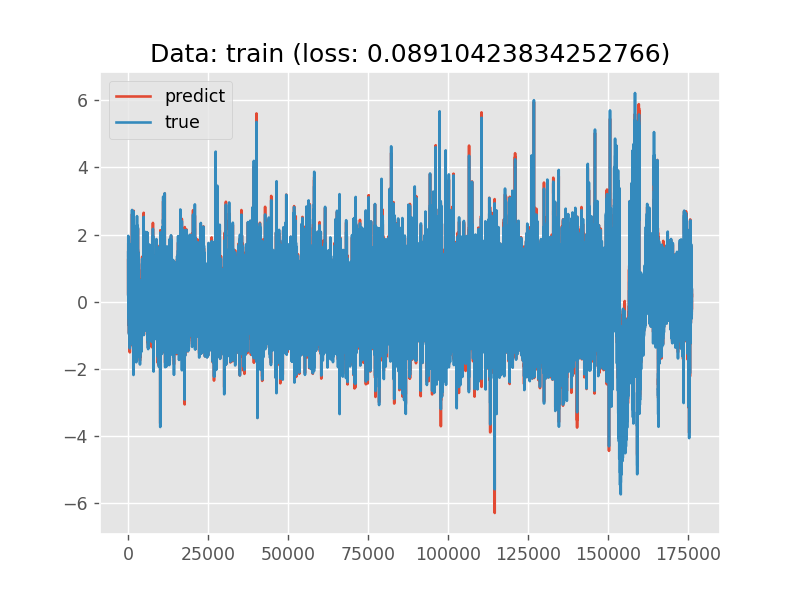

In [10]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = True
    
if trainPlotFlag:
    x = trainXTensor
    trainTitle = 'train'
else:
    x = validXTensor
    trainTitle = 'valididation'

model.to('cpu')
predict = model(x).cpu().detach().numpy()
model.to(device)

if predict.shape[1] == 1:
    yPred = predict[:,0]
    if trainPlotFlag:
        yTrue = yTrainTimeDomain[:,0]
    else:
        yTrue = yValidTimeDomain[:,0]
else:
    _, yPred = realSTFTtoTimeSeries(predict)
    if trainPlotFlag:
        y = y_trainRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
    else:
        y = y_validRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
        

lossTemp = loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item()
title = 'Data: ' + trainTitle + ' (loss: %s)' % str(lossTemp)
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()

# SCRATCH

In [ ]:
from scipy.signal import spectrogram, stft, istft, check_NOLA

fs = 1
nperseg = 32
noverlap = 31
#windowType = ('tukey', .25)
windowType = np.ones(nperseg)


a = np.random.rand(100)
f, t, S = stft(a, fs=fs, window=windowType, nperseg=nperseg, noverlap=noverlap)

b = torch.stft(torch.tensor(a), 
               n_fft = nperseg, 
               hop_length = 1, 
               return_complex=True, 
               normalized=False, 
               onesided=True, 
               pad_mode='constant').numpy()

np.abs(np.divide(b,S))

In [ ]:
# HOW TO GRAB DATA FROM NEPTUNE

project = neptune.init_project(project="jettinger35/predictScalp")
df = project.fetch_runs_table().to_pandas()
df[['sys/id','best_test_loss']]

In [21]:
from scipy.signal import get_window
a = get_window(('tukey', .25), nperseg)
a

array([0.        , 0.00960736, 0.03806023, 0.08426519, 0.14644661,
       0.22221488, 0.30865828, 0.40245484, 0.5       , 0.59754516,
       0.69134172, 0.77778512, 0.85355339, 0.91573481, 0.96193977,
       0.99039264, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     